# SHARENOW pickup location distribution

Credit for model to https://github.com/DanieleGammelli/pyro-torch-normalizing-flows

This notebook is split up into three sections going through different stages of the project 

    - Data loading and data treatment
    
    - Model initialisation and model training
    
    - Visualization

pyro == 1.5.1

torch == 1.7.0

tqdm == 4.51.0

numpy == 1.19.1

matplotlib == 3.3.1

pandas == 1.1.4

seaborn == 0.11.0

In [ ]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO
from torch.optim import Adam

import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math

from models.conditional_affine_coupling_nf import ConditionalNormalizingFlow

import pandas as pd
from sklearn import preprocessing
import time as time
from random import sample
import seaborn as sns
from IPython.display import clear_output

In [2]:
plt.style.use("ggplot")
%matplotlib inline

### Data loading and treatment

Start coordinates and index detailing the starting hour of the week is loaded into a dataframe. 50000 data points are taken out to be used for training. This data is then devided into batches in a Dataloader.

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]

In [ ]:
data = pd.read_csv('data_clean.csv', sep = ',')
data = data[['Start tidspunkt', 'Latitude (Start)', 'Longitude (Start)']]
weekday = np.zeros(len(data['Start tidspunkt']))
dayhour = np.zeros(len(data['Start tidspunkt']))

for i in range(len(data['Start tidspunkt'])):
    weekday[i] = time.strftime('%w', time.gmtime(data['Start tidspunkt'][i]))
    dayhour[i] = time.strftime('%H', time.gmtime(data['Start tidspunkt'][i]))
#weekday = weekday.astype(np.int)

data['Weekhour'] = weekday*24 + dayhour

data_tensor = torch.tensor(data.values, dtype=torch.float)
randin = torch.randint(len(data_tensor), (50000,))
mean, sd = [torch.mean(data_tensor[randin,1:3],0), np.sqrt(torch.var(data_tensor[randin,1:3],0))]
X_real = data_tensor[randin,1:3]
X_H = preprocessing.scale(X_real)
X_H = torch.tensor(X_H, dtype=torch.float)
H = data_tensor[randin,3]
H = H.unsqueeze(-1)
dataset = Dataset(H, X_H)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=200,
                      shuffle=True, num_workers=0)
for i in range(7*24):
    plt.figure(figsize=(4,4))
    idx = np.argwhere(np.asarray(H == i))
    plt.scatter(X_H[idx,1], X_H[idx,0], s=5, alpha=0.5)
    plt.axis('equal')
    plt.show()

### Model initialzation and training

We now define the model with the apropriate parameters, define optimizer, and train the model.

In [7]:
# Build NF model
cnf = ConditionalNormalizingFlow(input_dim=2, split_dim=1, context_dim=1, hidden_dim=24, num_layers=5, flow_length=10, 
                    use_cuda=False)

In [8]:
# Build SVI object
optimizer = pyro.optim.Adam({"lr": 0.0001})
svi = SVI(cnf.model, cnf.guide, optimizer, Trace_ELBO(num_particles=1))

In [139]:
num_epochs = 300
losses = []
pyro.clear_param_store()
epochs = tqdm.trange(num_epochs)

for epoch in epochs:
    try:
        running_loss = 0
        for x_batch, y_batch in dataloader:
            if cnf.use_cuda:
                y_batch, x_batch = y_batch.cuda(), x_batch.cuda()
            loss = svi.step(y_batch, x_batch)
            running_loss += float(loss)
            del x_batch, y_batch
            del loss
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
        del running_loss
    except KeyboardInterrupt:
        plt.plot(losses);
        break

ELBO: 111341.85: 100%|██████████| 300/300 [35:21<00:00,  7.07s/it]


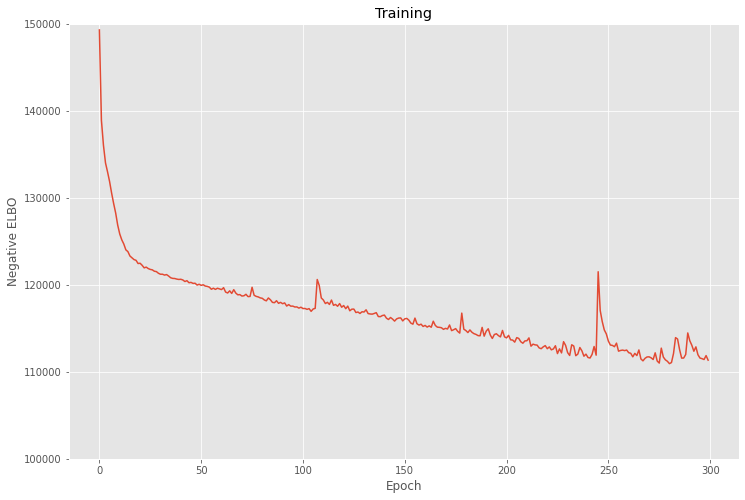

In [143]:
#torch.save(cnf, "cnf_torch_save_run_last")
plt.figure(figsize=(12, 8))
plt.plot(losses)
plt.ylim((100000,150000))
plt.ylabel('Negative ELBO')
plt.xlabel('Epoch')
plt.title('Training')
plt.savefig('training_plot.pdf')
plt.show()

### Visualization

In [10]:
cnf = torch.load("cnf_torch_save_run_last")

#### Sampled points

This plots data points sampled by the model togeather with the real data points at all hours during a week.

In [ ]:
for i in range(7*24):
    if i%24 == 0:
        clear_output(wait=True)
    samples = cnf.sample(num_samples=200, H=torch.zeros(200,1)+i).detach()
    samples = (samples*sd + mean)
    idx = np.argwhere(np.asarray(H == i))
    fig = plt.figure(figsize=(10,8))
    plt.xlim(12.45, 12.7)
    plt.ylim(55.5, 55.8)
    plt.scatter(X_real[idx,1], X_real[idx,0], c="b", label="Data", alpha=0.8)
    plt.scatter(samples[:, 1], samples[:, 0], c="r", alpha=0.5, label="z --> x")
    plt.title('Weekday: {}'.format(i//24) + 'Hour: {}'.format(i%24))
    plt.legend()

#### Simulated densities

Simulates densities for all the different hours in a week.

In [ ]:

for i in range(7*24):
    samples = cnf.sample(num_samples=20000, H=torch.zeros(20000,1)+i).detach()
    samples1 = (samples*sd + mean)
    x, y = samples1[:, 1].numpy(), samples1[:, 0].numpy()
    clear_output(wait=True)
    plt.title('Weekday: {}'.format(i//24) + ' Hour: {}'.format(i%24))
    plt.hist2d(x, y, cmap=plt.cm.BuGn_r, bins = 100, range=[[12.45, 12.7], [55.5, 55.8]])
    plt.show()


#### Likelihoods and data

Evaluates the likelihood and plots it togeather with the data for every point in time.

In [ ]:

for i in range(24*7):
    idx = np.argwhere(np.asarray(H == i))
    x, y = X_H[idx, 1].numpy(), X_H[idx, 0].numpy() 
    a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
    grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
    df = cnf.log_prob(grid2, torch.zeros(1)+i)
    plt.figure(figsize=(15, 15))
    plt.scatter(x, y, c="orange", s=10)
    im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                    alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
    plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
    plt.xticks([])
    plt.yticks([])
    clear_output(wait=True)
    plt.show()

Likelihood and data at different points in time.

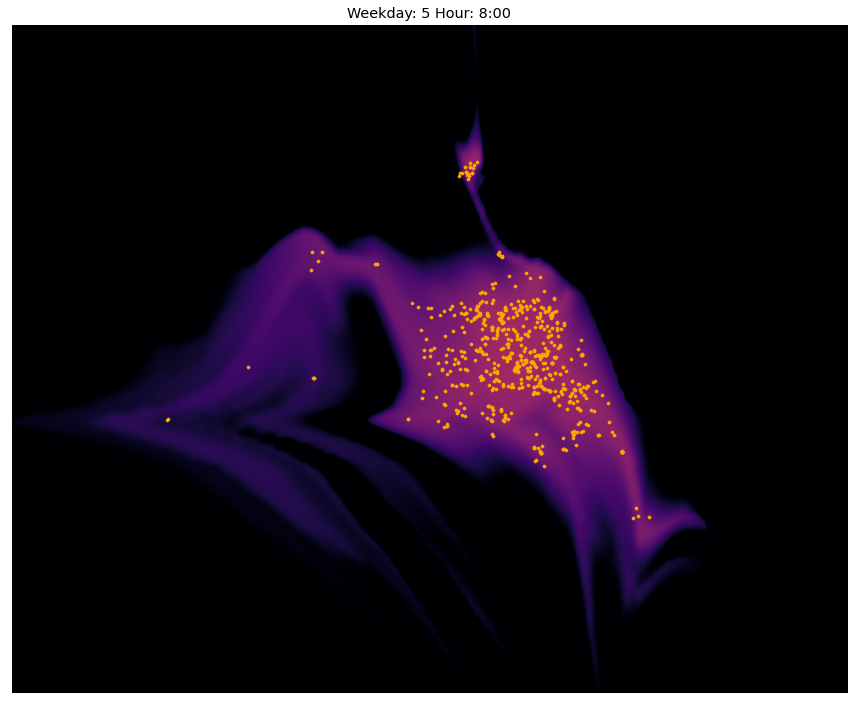

In [11]:
i = 128
idx = np.argwhere(np.asarray(data_tensor[:,3] == i))
x, y = ((data_tensor[idx, 2]-mean[1])/sd[1]).numpy(), ((data_tensor[idx, 1]-mean[0])/sd[0]).numpy()
a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
df = cnf.log_prob(grid2, torch.zeros(1)+i)
plt.figure(figsize=(15, 15))
plt.scatter(x, y, c="orange", s=10)
im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
plt.xticks([])
plt.yticks([])
plt.savefig('results_5_8:00.pdf')
plt.show()

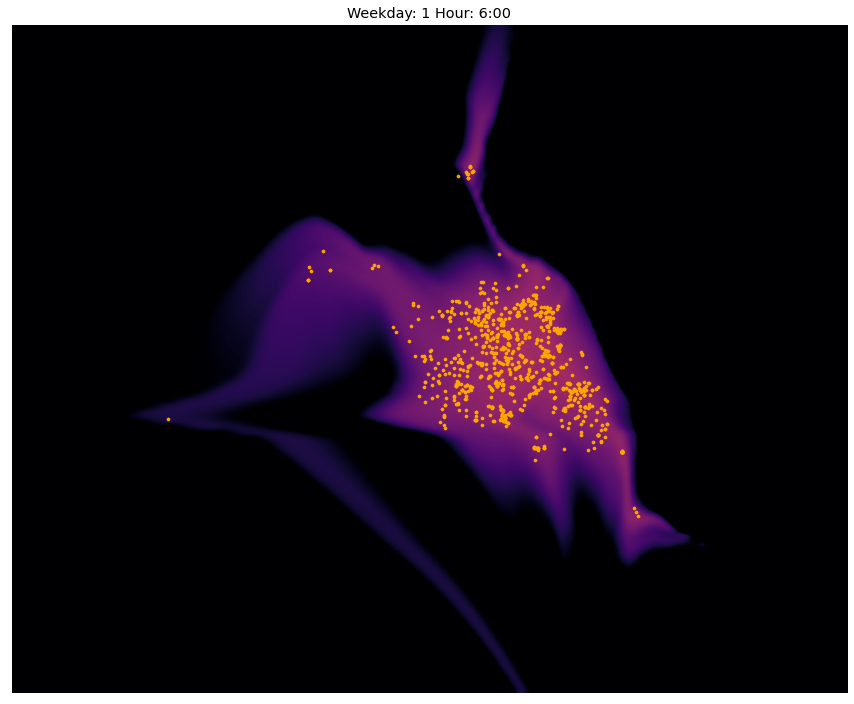

In [12]:
i = 30
idx = np.argwhere(np.asarray(data_tensor[:,3] == i))
x, y = ((data_tensor[idx, 2]-mean[1])/sd[1]).numpy(), ((data_tensor[idx, 1]-mean[0])/sd[0]).numpy()
a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
df = cnf.log_prob(grid2, torch.zeros(1)+i)
plt.figure(figsize=(15, 15))
plt.scatter(x, y, c="orange", s=10)
im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
plt.xticks([])
plt.yticks([])
plt.savefig('results_1_6:00.pdf')
plt.show()

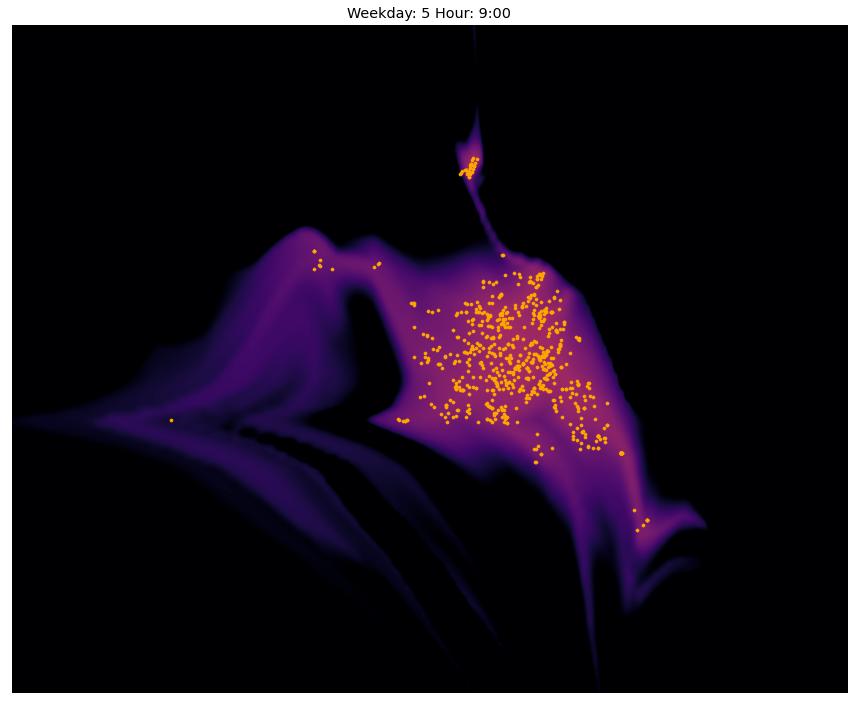

In [152]:
i = 129
idx = np.argwhere(np.asarray(data_tensor[:,3] == i))
x, y = ((data_tensor[idx, 2]-mean[1])/sd[1]).numpy(), ((data_tensor[idx, 1]-mean[0])/sd[0]).numpy()
a,b = torch.meshgrid([torch.arange(-6,6, step = 0.1), torch.arange(-9,6, step = 0.1)])
grid2 = torch.cat([a.unsqueeze(-1), b.unsqueeze(-1)], dim = 2)
df = cnf.log_prob(grid2, torch.zeros(1)+i)
plt.figure(figsize=(15, 15))
plt.scatter(x, y, c="orange", s=10)
im = plt.imshow(df.detach().numpy(), origin="lower", interpolation="bicubic",
                alpha=1, vmax=10., vmin=-10., cmap="inferno", extent=(-9, 6, -6, 6))
plt.title('Weekday: {}'.format(i//24) + ' Hour: {}:00'.format(i%24))
plt.xticks([])
plt.yticks([])
plt.show()